# Minimize input model

This notebook can experiment with the input data. such as training only on the sequence, energy terms, or remove some of the sequences such as mhc or peptide

### Load Libraries

In [1]:
import torch
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from torch import nn, optim, cuda
from utils import Runner, EarlyStopping, load_data, setup_seed
from network import Net
import pandas as pd

Set general plotting parameters for matplotlib using seaborn

In [2]:
custom_params = {"axes.spines.right": False, "axes.spines.top": False}
sns.set_theme(style="ticks", rc=custom_params, palette="pastel")

### General parameters

In [3]:
# General parameters
data_path = "../data/"
partitions = {"train" : [3, 4, 2], "validation" : 1, "test" : 5}    # Which partitions to use
device = torch.device("cuda" if cuda.is_available() else "cpu")
batch_size = 64
seed= 123

setup_seed(seed)


## Define Network parameters

For now just have the network parameters be defined here. They should perhaps be moved later

## Load Data

In [4]:

########### Select Indexes ############

# Full model
#idx = np.arange(420)

# peptide + TCR
#idx = np.arange(179,420)

# MHC + TCR
#idx = np.concatenate([np.arange(179),np.arange(192,420)])

# TCR
#idx = np.arange(192,420)

# MHC + peptide
idx = np.arange(192)

########### Select Features ###########

# All features
#local_features = np.arange(27)
#global_features = np.arange(27, 54)
#use_global_features = True

# Sequence
#local_features = np.arange(20)
#global_features = None
#use_global_features = False

# Energy terms
local_features = np.arange(20, 27)
global_features = np.arange(27, 54)
use_global_features = True

# Sequence and global energy
#local_features = np.arange(20)
#global_features = np.arange(27, 54)
#use_global_features = True

net = Net(local_features, global_features, use_global_features)
print(net)


Net(
  (conv1): Conv1d(7, 100, kernel_size=(3,), stride=(2,), padding=(1,))
  (conv2): Conv1d(100, 100, kernel_size=(3,), stride=(2,), padding=(1,))
  (pool): MaxPool1d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (rnn1): LSTM(100, 26, batch_first=True, bidirectional=True)
  (rnn2): LSTM(52, 26, batch_first=True, bidirectional=True)
  (rnn3): LSTM(52, 26, batch_first=True, bidirectional=True)
  (dense1): Linear(in_features=79, out_features=60, bias=True)
  (dense2): Linear(in_features=60, out_features=60, bias=True)
  (dense3): Linear(in_features=60, out_features=1, bias=True)
  (bn_start): BatchNorm1d(7, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (bn_cnn1): BatchNorm1d(100, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (bn_cnn2): BatchNorm1d(100, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (bn_dense): BatchNorm1d(79, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (drop): Dropout(p

In [5]:
train_dl, x_train, y_train = load_data(data_path, partitions["train"], batch_size, idx, seed)
val_dl, x_val, y_val = load_data(data_path, partitions["validation"], batch_size, idx, seed)
test_dl, x_test, y_test = load_data(data_path, partitions["test"], batch_size, idx, seed)

In [6]:
#Hyperparameters
epochs = 100
patience = 15
lr = 0.001
loss_weight = sum(y_train) / len(y_train)


# Loss and optimizer
criterion = nn.BCELoss(reduction='none')
optimizer = optim.Adam(net.parameters(), lr=lr,
    weight_decay=0.0005,
    amsgrad=True
)

stopper = EarlyStopping(patience)
# Define runners
train_runner = Runner(train_dl, net, criterion, loss_weight, optimizer)
val_runner = Runner(val_dl, net, criterion, loss_weight)
test_runner = Runner(test_dl, net, criterion, loss_weight)

## Training Loop

In [7]:
train_loss, val_loss = [], []

for epoch in range(1, epochs+1):
    train_runner.run_epoch()
    val_runner.run_epoch()
    
    train_runner.follow_performance(epoch)
    val_runner.follow_performance(epoch)
    stopper.evaluate_epoch(val_runner, net, epoch)
    
    train_loss.append(train_runner.loss)
    val_loss.append(val_runner.loss)
    
    train_runner.reset()
    val_runner.reset()

    if stopper.stop:
        break


Epoch: 1
Train loss: 0.0052751527448590295 Train MCC: 0.013278122606185844
Validation loss: 0.004039941265261189 Validation MCC: 0.09330427796951254
Validation loss decreased. Counter reset
Epoch: 2
Train loss: 0.004749278474652596 Train MCC: 0.036191467559378306
Validation loss: 0.004024579671857241 Validation MCC: 0.11107289979429108
Validation loss decreased. Counter reset
Epoch: 3
Train loss: 0.004492489116613945 Train MCC: 0.016302885922604666
Validation loss: 0.003976753467344832 Validation MCC: 0.15323179631792086
Validation loss decreased. Counter reset
Epoch: 4
Train loss: 0.0042922412379506674 Train MCC: 0.06313790825853892
Validation loss: 0.003891726152612529 Validation MCC: 0.19796505268860345
Validation loss decreased. Counter reset
Epoch: 5
Train loss: 0.004293421695106908 Train MCC: 0.04369662191557422
Validation loss: 0.0038423313225862394 Validation MCC: 0.19127262391302147
Validation loss decreased. Counter reset
Epoch: 6
Train loss: 0.0041570996553703925 Train MCC: 

(Text(0.5, 0, 'Epoch'), Text(0, 0.5, 'Loss'))

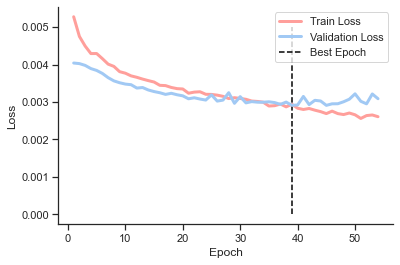

In [8]:
# Plots of training epochs
epoch = np.arange(1, len(train_loss) + 1)
plt.figure()
plt.plot(epoch, train_loss, "r", epoch, val_loss, "b", linewidth=3)
plt.vlines(stopper.best_epoch, ymin=0, ymax=0.005, colors="black", linestyles='dashed')
plt.legend(["Train Loss", "Validation Loss", "Best Epoch"])
plt.xlabel("Epoch"), plt.ylabel("Loss")

## Evaluate using the best model

Best model is stored as early_stopping_state.pt and loaded into a new object

In [9]:
final_model = Net(local_features, global_features, use_global_features)
final_model.load_state_dict(torch.load("early_stopping_state.pt"))
train_runner.model = final_model
val_runner.model = final_model
test_runner.model = final_model

In [10]:
train_runner.reset()
val_runner.reset()
test_runner.reset()

train_runner.evaluation_mode() # Set to validation to avoid more training
train_runner.run_epoch()
val_runner.run_epoch()
test_runner.run_epoch()

Evaluation on Training Data:
Loss: 0.0025009659488805743
MCC: 0.6198892744281642
Confussion Matrix:
 [[2938  197]
 [ 372  673]] 

Evaluation on Validation Data:
Loss: 0.0029102121705621444
MCC: 0.5381072747850008
Confussion Matrix:
 [[1042  104]
 [ 150  230]] 

Evaluation on Test Data:
Loss: 0.0032984765976445183
MCC: 0.4927546777132379
Confussion Matrix:
 [[835  71]
 [143 158]] 



Text(0.5, 1.0, 'Test Data')

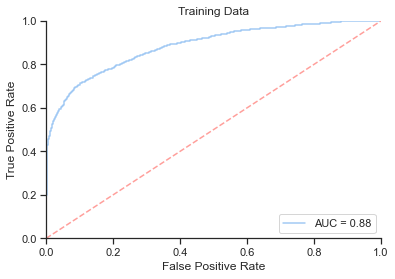

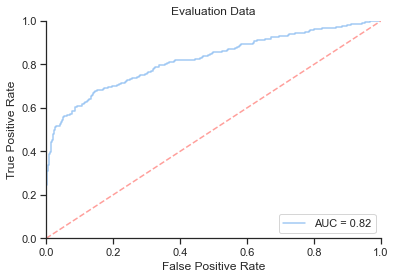

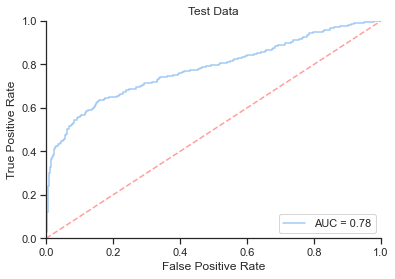

In [11]:
print("Evaluation on Training Data:")
train_runner.evaluate_model()
plt.title("Training Data")

print("Evaluation on Validation Data:")
val_runner.evaluate_model()
plt.title("Evaluation Data")

print("Evaluation on Test Data:")
test_runner.evaluate_model()
plt.title("Test Data")



In [13]:
arrays=[np.array(["all_feat", "all_feat", "all_feat", "all_feat", "all_feat",
       "sequence", "sequence", "sequence", "sequence", "sequence",
       "energy_terms", "energy_terms", "energy_terms", "energy_terms", "energy_terms",
       "seq_globalenergy", "seq_globalenergy", "seq_globalenergy", "seq_globalenergy", "seq_globalenergy"])
       ,
       np.array(["full_model", "peptide_tcr", "mhc_tcr", "tcr", "peptide_mhc",
       "full_model", "peptide_tcr", "mhc_tcr", "tcr", "peptide_mhc",
       "full_model", "peptide_tcr", "mhc_tcr", "tcr", "peptide_mhc",
       "full_model", "peptide_tcr", "mhc_tcr", "tcr", "peptide_mhc"])]

pd.DataFrame({"training_loss" : [0.00177, 0.00162, 0.00220, 0.226, 0.00407, 0.00220, 0.00174, 0.00340, 0.00344, 0.00397, 0.00183, 0.00181, 0.00196, 0.00233, 0.00250, None, None, None, None, None],
              "validation_loss" : [0.00221, 0.00230 , 0.00272, 0.00321, 0.00405, 0.00238, 0.00227, 0.00363, 0.00360, 0.00395, 0.00265, 0.00246, 0.00271, 0.00322, 0.00291, None, None, None, None, None],
              "test_loss" : [0.00271, 0.00279, 0.00312, 0.00344, 0.00409, 0.00267, 0.00271, 0.00377, 0.00371, 0.00403, 0.00308, 0.00289, 0.00313, 0.00361, 0.00330, None, None, None, None, None],
              "auc_train" : [0.95, 0.96, 0.91, 0.88, 0.60, 0.92, 0.95, 0.77, 0.76, 0.60, 0.94, 0.94, 0.93, 0.92, 0.88, None, None, None, None, None],
              "auc_val" : [0.91, 0.91, 0.84, 0.79, 0.62, 0.90, 0.90, 0.72, 0.73, 0.61, 0.87, 0.89, 0.85, 0.79, 0.82, None, None, None, None, None],
              "auc_test" : [0.86, 0.86, 0.78, 0.76, 0.54, 0.87, 0.87, 0.70, 0.70, 0.57, 0.83, 0.85, 0.81, 0.74, 0.78, None, None, None, None, None],
              "mcc_train" : [0.75, 0.70, 0.69, 0.55, 0.095, 0.63, 0.61, 0.36, 0.37, 0.18, 0.72, 0.61, 0.67, 0.62, 0.62, None, None, None, None, None],
              "mcc_val" : [0.63, 0.56, 0.58, 0.45, 0.14, 0.54, 0.55, 0.32, 0.32, 0.18, 0.58, 0.51, 0.57, 0.44, 0.54, None, None, None, None, None], 
              "mcc_test" : [0.54, 0.52, 0.51, 0.41, 0.047, 0.49, 0.47, 0.31, 0.31, 0.12, 0.52, 0.47, 0.53, 0.37, 0.49, None, None, None, None, None]}, index=arrays)

training_loss  validation_loss  test_loss  \
all_feat         full_model         0.00177          0.00221    0.00271   
                 peptide_tcr        0.00162          0.00230    0.00279   
                 mhc_tcr            0.00220          0.00272    0.00312   
                 tcr                0.22600          0.00321    0.00344   
                 peptide_mhc        0.00407          0.00405    0.00409   
sequence         full_model         0.00220          0.00238    0.00267   
                 peptide_tcr        0.00174          0.00227    0.00271   
                 mhc_tcr            0.00340          0.00363    0.00377   
                 tcr                0.00344          0.00360    0.00371   
                 peptide_mhc        0.00397          0.00395    0.00403   
energy_terms     full_model         0.00183          0.00265    0.00308   
                 peptide_tcr        0.00181          0.00246    0.00289   
                 mhc_tcr            0.00196          0.00271    0.00313   
                 tcr                0.00233          0.00322    0.00361   
                 peptide_mhc        0.00250          0.00291    0.00330   
seq_globalenergy full_model             NaN              NaN        NaN   
                 peptide_tcr            NaN              NaN        NaN   
                 mhc_tcr                NaN              NaN        NaN   
                 tcr                    NaN              NaN        NaN   
                 peptide_mhc            NaN              NaN        NaN   

                              auc_train  auc_val  auc_test  mcc_train  \
all_feat         full_model        0.95     0.91      0.86      0.750   
                 peptide_tcr       0.96     0.91      0.86      0.700   
                 mhc_tcr           0.91     0.84      0.78      0.690   
                 tcr               0.88     0.79      0.76      0.550   
                 peptide_mhc       0.60     0.62      0.54      0.095   
sequence         full_model        0.92     0.90      0.87      0.630   
                 peptide_tcr       0.95     0.90      0.87      0.610   
                 mhc_tcr           0.77     0.72      0.70      0.360   
                 tcr               0.76     0.73      0.70      0.370   
                 peptide_mhc       0.60     0.61      0.57      0.180   
energy_terms     full_model        0.94     0.87      0.83      0.720   
                 peptide_tcr       0.94     0.89      0.85      0.610   
                 mhc_tcr           0.93     0.85      0.81      0.670   
                 tcr               0.92     0.79      0.74      0.620   
                 peptide_mhc       0.88     0.82      0.78      0.620   
seq_globalenergy full_model         NaN      NaN       NaN        NaN   
                 peptide_tcr        NaN      NaN       NaN        NaN   
                 mhc_tcr            NaN      NaN       NaN        NaN   
                 tcr                NaN      NaN       NaN        NaN   
                 peptide_mhc        NaN      NaN       NaN        NaN   

                              mcc_val  mcc_test  
all_feat         full_model      0.63     0.540  
                 peptide_tcr     0.56     0.520  
                 mhc_tcr         0.58     0.510  
                 tcr             0.45     0.410  
                 peptide_mhc     0.14     0.047  
sequence         full_model      0.54     0.490  
                 peptide_tcr     0.55     0.470  
                 mhc_tcr         0.32     0.310  
                 tcr             0.32     0.310  
                 peptide_mhc     0.18     0.120  
energy_terms     full_model      0.58     0.520  
                 peptide_tcr     0.51     0.470  
                 mhc_tcr         0.57     0.530  
                 tcr             0.44     0.370  
                 peptide_mhc     0.54     0.490  
seq_globalenergy full_model       NaN       NaN  
                 peptide_tcr      NaN       NaN  
                 mhc

## Inspect Dataset

In [5]:

def reverseOneHot(encoding):
    """
    Converts one-hot encoded array back to string sequence
    """
    mapping = dict(zip(range(20),"ACDEFGHIKLMNPQRSTVWY"))
    seq=''
    for i in range(len(encoding)):
        if np.max(encoding[i])>0:
            seq+=mapping[np.argmax(encoding[i])]
    return seq

def extract_sequences(dataset_X):
    """
    Return DataFrame with MHC, peptide and TCR a/b sequences from
    one-hot encoded complex sequences in dataset X
    """
    mhc_sequences = [reverseOneHot(arr[0:179,0:20]) for arr in dataset_X]
    pep_sequences = [reverseOneHot(arr[179:190,0:20]) for arr in dataset_X]
    tcr_sequences = [reverseOneHot(arr[192:,0:20]) for arr in dataset_X]
    df_sequences = pd.DataFrame({"MHC":mhc_sequences, "peptide":pep_sequences,
                                 "tcr":tcr_sequences})
    return df_sequences

In [7]:
print(x_val.shape)


(1526, 241, 54)
